In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
import scipy
from scipy import ndimage
from scipy.ndimage import zoom
from statistics import mean
from scipy.interpolate import splrep, BSpline
from scipy import interpolate
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d

(-0.5, 1199.5, 479.5, -0.5)

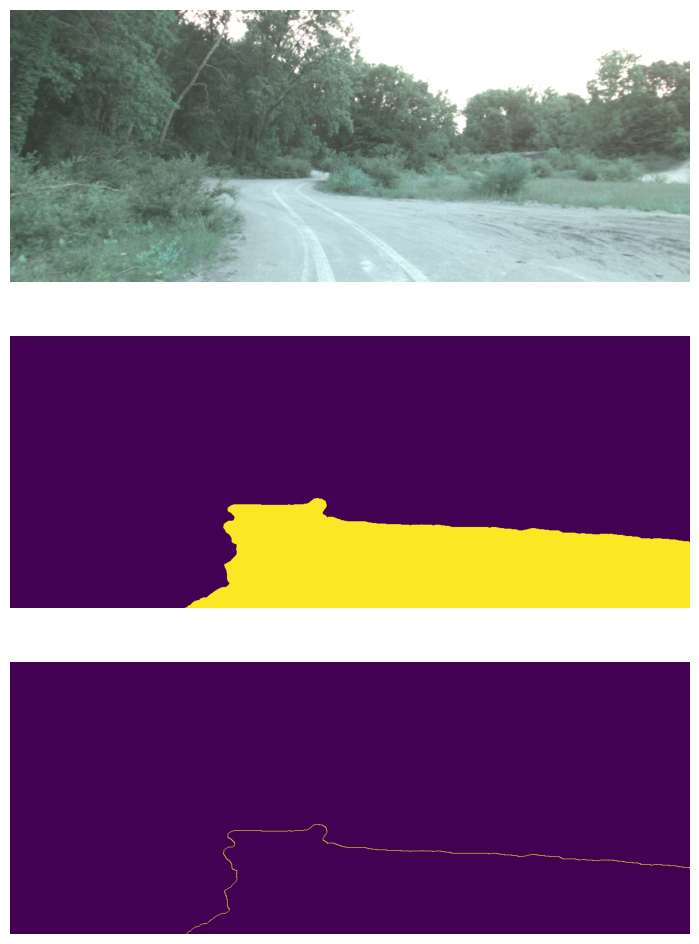

In [42]:
rgb = cv2.imread('/home/data/RGB/rgb2301310584.png', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('/home/data/Label/label2301310584.png', cv2.IMREAD_UNCHANGED)
fig, axs = plt.subplots(3, figsize=(9, 12))
axs[0].imshow(rgb)
axs[0].axis('off')
axs[1].imshow(mask)
axs[1].axis('off')
X, Y = rgb.shape[0], rgb.shape[1]
H, W = mask.shape[0], mask.shape[1]

overlay = rgb.copy()
rgb[mask == 1] = [100, 0, 0]

region =  (0<mask)
edgex = (np.roll(region,shift=1,axis=0) ^ region)
edgey = (np.roll(region,shift=1,axis=1) ^ region)
#edgex = (np.roll(region,shift=1,axis=0) ^ np.roll(region,shift=-1,axis=0))
#edgey = (np.roll(region,shift=1,axis=1) ^ np.roll(region,shift=-1,axis=1))
edge = edgex | edgey
edge[:, 0] = edge[:, 1]
edge[:, -1] = edge[:, -2]
edge[0, :] = edge[1, :]
edge[-1, :] = edge[-2, :]
edge = 1 * edge
axs[2].imshow(edge)
axs[2].axis('off')

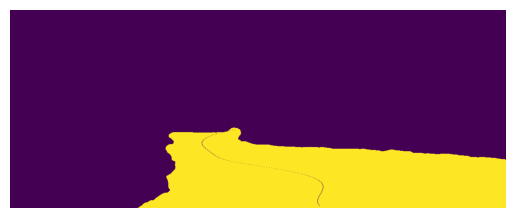

In [43]:
count = 0;
topVector = np.empty((0,1), np.int8)
length = 1
maxLength = 1
for x in range(0, H-1):
    line = edge[x,:]
    if(1 not in line): continue
    count = count + 1
    pos = np.where(line == 1)
    topVector = np.append(topVector, pos)
    if(count == 6):
        # search for top
        topVector = np.sort(topVector)
        l = 0
        while(l < topVector.size - 1):
            for r in range(l+1, topVector.size):
                if(topVector[r] - topVector[r-1] < 2):
                    length = length + 1
                    if(length > maxLength):
                        maxLength = length
                        left = topVector[l]
                        right = topVector[r]
                else:
                    break
            l = r
            length = 1
        break

Xtop = x
leftLine = np.empty((0,2), np.int8)
rightLine = np.empty((0,2), np.int8)
midLine = np.empty((0,2), np.int8)
preMidPointInt = int((left+right)/2)
for x in range(Xtop, H-1):
    line = np.squeeze(edge[x, :])
    if(1 in line[0:preMidPointInt]):
        left = np.where(line[0:preMidPointInt] == 1)[0][-1]
        leftLine = np.vstack((leftLine, [x, left]))
    if(1 in line[preMidPointInt:W-1]):
        right = np.where(line[preMidPointInt:W-1] == 1)[0][0] + preMidPointInt
        rightLine = np.vstack((rightLine, [x, right]))
    preMidPointInt = int((left+right)/2)

if(leftLine.shape[0] > 10 and rightLine.shape[0] > 10):
    left = leftLine[-1][0]
    if(leftLine.shape[0] * 2 < H - left):
        Xtop = left
        leftLine = np.empty((0,2), np.int8)
        for x in range(left+1, H-1):
            leftLine = np.vstack((leftLine, [x, 1]))
    right = rightLine[-1][0]
    if(rightLine.shape[0] * 2 < H - right):
        Xtop = right
        rightLine = np.empty((0,2), np.int8)
        for x in range(right+1, H-1):
            rightLine = np.vstack((leftLine, [x, 1]))

    lxLine, lyLine = np.hsplit(leftLine, 2)
    lxLine = np.squeeze(lxLine)
    lyLine = np.squeeze(lyLine)

    count = 8 #int((H-Xtop)/36)
    lp = np.polyfit(lxLine, lyLine, deg=3)
    lxs = np.linspace(lxLine[0], lxLine[-1], count)
    lys = np.polyval(lp, lxs)

    ltck = interpolate.splrep(lxLine, lyLine, s=0)
    lxnew = np.linspace(lxLine[0], lxLine[-1], count) #np.arange(0, 2*np.pi, np.pi/50)
    lynew = interpolate.splev(lxnew, ltck, der=0)

    rxLine, ryLine = np.hsplit(rightLine, 2)
    rxLine = np.squeeze(rxLine)
    ryLine = np.squeeze(ryLine)
    rtck = interpolate.splrep(rxLine, ryLine, s=0)
    rxnew = np.linspace(rxLine[0], rxLine[-1], count) #np.arange(0, 2*np.pi, np.pi/50)
    rynew = interpolate.splev(rxnew, rtck, der=0)

    mxLine = (lxnew + rxnew) / 2
    myLine = (lynew + rynew) / 2
    axs[2].plot(myLine, mxLine, color='blue')
    tck = splrep(mxLine, myLine, s=0)
    mxnew = range(Xtop, H-5)
    mynew = BSpline(*tck)(mxnew)
    mynew = np.clip(mynew, 0, 1199)
    axs[2].plot(mynew, mxnew, color='red')

    mxLine = np.append(mxLine, H-1)
    myLine = np.append(myLine, myLine[-1])
    tck = splrep(mxLine, myLine, s=0)
    mxnew = range(Xtop, H-5)
    mynew = BSpline(*tck)(mxnew)
    mynew = np.clip(mynew, 0, 1199)
    axs[2].plot(mynew, mxnew, color='yellow')

    for i in range(0, len(mxnew)):
        x = mxnew[i]
        y = int(mynew[i])
        mask[x,y] = 2
    plt.figure()
    plt.imshow(mask)
    plt.axis('off')